In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ipdl_dir = os.path.join(project_dir, 'modules/SVDD')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

import numpy as np
import torch
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

subject_data = np.nan_to_num(np.concatenate(subject_data))
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])

In [3]:
import scipy.linalg as splin

def _proj_subspace(X, d):
    '''
        Project data onto a subspace d. This method uses SVD. SVD and PCA are
        also equal in the case of zero-mean data.

        Params
        -----
        X : array, shape (n_features, n_samples)
            Data that will be projected in the subspace d.

        d : int
            Space where the zero-mean data will be projected.

        Return
        ------
            (Data projected onto subspace d, Tranform matrix which project data onto d-space).
    '''
    _, N = X.shape
    Ud  = splin.svd(np.dot(X,X.T)/float(N))[0][:,:d]   # computes the d-projection matrix 
    return (np.dot(Ud.T, X), Ud)

In [4]:
#Undersampling
from numpy.random import default_rng

rng = default_rng(seed=123)
numbers = rng.choice(len(data), size=3000, replace=False)
data_resampled = data[numbers]

In [5]:
n_endmembers = 2

data_p, Ud = _proj_subspace(data_resampled.T, n_endmembers)

In [13]:
from HySpecLab.dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get()

In [14]:
from HySpecLab.transform import Norm1Transform, StandarizedTransform

transform = StandarizedTransform()
x = transform.fit_transform(x)

In [15]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Randomly selecting a subset of data for the targeted classes:
# rus = RandomUnderSampler(random_state=123)
# x, y = rus.fit_resample(x, y)

# # Let positive samples be the samples belonging to the targeted class to be under-sampled. 
# # Negative sample refers to the samples from the minority class.
# # Select the positive samples for which the average distance to the N closest samples of the negative 
# # class is the smallest
sampling_strategy = {0: 1500, 1: 1500}
nm = NearMiss(sampling_strategy=sampling_strategy, version=1)
x, y = dataset.get(dataframe=False)
X_resampled, y_resampled = nm.fit_resample(x, y)

In [16]:
n_endmembers = 2

data_p, Ud = _proj_subspace(X_resampled.T, n_endmembers)

In [17]:
n, d = data_resampled.shape
sigma = 0.1 * (n ** (-1 / (4 + d)))
print(sigma)

0.09354573454818554


In [22]:
from SVDD import BaseSVDD

y_svdd = y_resampled.copy()
y_svdd[y_svdd==0] = -1

eea = BaseSVDD(C=100, gamma=sigma, kernel='rbf', display='on')
eea.fit(data_p.T)
# eea.fit(X_resampled)
# eea.fit(data_p.T, y_svdd.reshape(-1,1))



*** Fitting of the SVDD model is completed. ***

running time         = 15.2740 seconds
kernel function      = rbf
iterations           = 16
number of samples    = 3000
number of features   = 2
number of SVs        = 6
ratio of SVs         = 0.2000 %
accuracy             = 99.9000 %




BaseSVDD(C=[100, 1], gamma=0.09354573454818554)

In [23]:
eea.support_vector_indices

array([ 424,  700, 1084, 2623, 2936, 2975])

In [21]:
eea.support_vector_indices

array([ 361,  424,  700,  962, 1084, 2462, 2623, 2898, 2936, 2975])

Calculating the grid scores (0050*0050)...

Calculation of the grid scores is completed. Time cost 0.2480 seconds



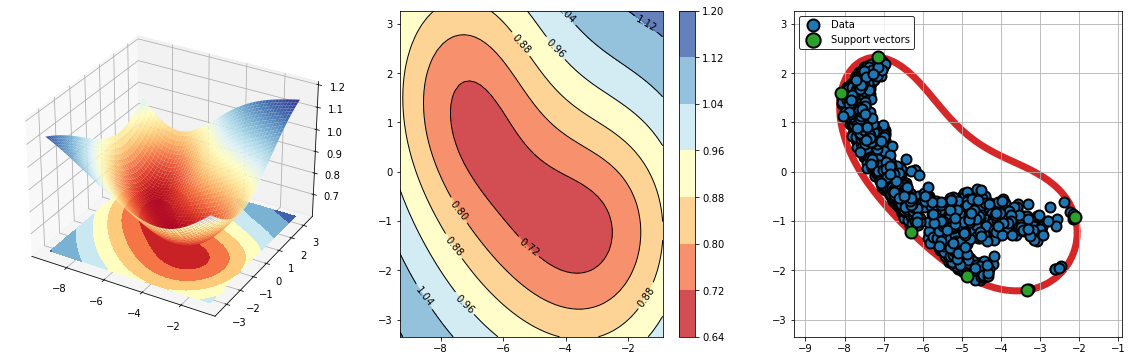

In [19]:
eea.plot_boundary(data_p.T)

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(data_p[0], data_p[1])

In [ ]:
from SVDD import BaseSVDD
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])

eea = BaseSVDD(C=0.9, gamma=0.3, kernel='rbf', display='on')
eea.fit(data[:3000])
# endmembers = eea.fit_transform(data)

In [ ]:
from HySpecLab.dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Randomly selecting a subset of data for the targeted classes:
# rus = RandomUnderSampler(random_state=123)
# x, y = rus.fit_resample(x, y)

# # Let positive samples be the samples belonging to the targeted class to be under-sampled. 
# # Negative sample refers to the samples from the minority class.
# # Select the positive samples for which the average distance to the N closest samples of the negative 
# # class is the smallest
sampling_strategy = {0: 1500, 1: 1500}
nm = NearMiss(sampling_strategy=sampling_strategy, version=1)
x, y = dataset.get(dataframe=False)
X_resampled, y_resampled = nm.fit_resample(x, y)

In [ ]:
import scipy.linalg as splin

def _proj_subspace(X, d):
    '''
        Project data onto a subspace d. This method uses SVD. SVD and PCA are
        also equal in the case of zero-mean data.

        Params
        -----
        X : array, shape (n_features, n_samples)
            Data that will be projected in the subspace d.

        d : int
            Space where the zero-mean data will be projected.

        Return
        ------
            (Data projected onto subspace d, Tranform matrix which project data onto d-space).
    '''
    _, N = X.shape
    Ud  = splin.svd(np.dot(X,X.T)/float(N))[0][:,:d]   # computes the d-projection matrix 
    return (np.dot(Ud.T, X), Ud)

In [ ]:
n_endmembers = 3

data_p, Ud = _proj_subspace(X_resampled.T, n_endmembers)

In [ ]:
Xp = np.dot(Ud,data_p[:n_endmembers,:]) # again in dimension L (note that X_p has no zero mean)

In [ ]:
n, d = X_resampled.shape
sigma = 0.1 * (n ** (-1 / (4 + d)))
print(sigma)

In [ ]:
from SVDD import BaseSVDD

eea = BaseSVDD(C=0.9, gamma=sigma, kernel='rbf', display='off')
eea.fit(data_p.T)

In [ ]:
print(eea.support_vector_indices)
print(eea.support_vector_alpha)
choosen = np.argsort(eea.support_vector_alpha, axis=0)[-(n_endmembers+1)::].flatten()
print(eea.support_vector_alpha[choosen])
print(eea.support_vector_indices[choosen])

eea.support_vector_alpha = eea.support_vector_alpha[choosen]
eea.support_vector_indices = eea.support_vector_indices[choosen]
# print(sv_idx)

In [ ]:
eea.plot_boundary(data_p.T)

In [ ]:
result = Xp.T[eea.support_vector_indices]

In [ ]:
from matplotlib import pyplot as plt
plt.plot(result.T)

In [ ]:
eea = BaseSVDD(C=0.9, gamma=sigma, kernel='rbf', display='off')
eea.fit(X_resampled)

In [ ]:
print(eea.support_vector_indices)
print(eea.support_vector_alpha)
choosen = np.argsort(eea.support_vector_alpha, axis=0)[-(n_endmembers+1)::].flatten()
print(eea.support_vector_alpha[choosen])
print(eea.support_vector_indices[choosen])

eea.support_vector_alpha = eea.support_vector_alpha[choosen]
eea.support_vector_indices = eea.support_vector_indices[choosen]

In [ ]:
result = X_resampled[eea.support_vector_indices]

In [ ]:
from matplotlib import pyplot as plt
plt.plot(result.T)